In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['fra-eng']


# Learning to speak French

French is hard. But slowly, machines are getting good at translating English to French. This notebook is an adaptation of Francois Chollet's [A ten-minute introduction to sequence-to-sequence learning in Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) with faster code, optimized for training on a GPU. Read his tutorial for a full overview of what is going on. I tried to comment the code well so that you can read along. 

In [2]:
from keras.models import Model
from keras.layers import Input, CuDNNLSTM, Dense
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../input/fra-eng/fra.txt'

In [4]:
# docs = ['Well done!',
# 		'Good work',
# 		'Great effort',
# 		'nice work',
# 		'Excellent!',
# 		'Weak',
# 		'Poor effort!',
# 		'not good',
# 		'poor work',
# 		'Could have done better.']

In [5]:
# tokenized_docs = [text_to_word_sequence(doc) for doc in docs]

In [6]:
# t = Tokenizer()
# t.fit_on_texts(docs)

In [7]:
# word_index = t.word_index

In [8]:
# index_word = {idx:word for (word,idx) in word_index.items()}

In [9]:
# integer_encoded_docs = []

In [10]:
# for doc in tokenized_docs:
#     encoded = [word_index[word] for word in doc]
#     integer_encoded_docs.append(encoded)

In [11]:
# text = 'The cat sat on the mat.'
# encoded = one_hot(text, 5)

In [12]:
# max_length = 4
# padded_docs = pad_sequences(integer_encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)

## The data
The data is present in a tab delimited CSV file. To give it a quick overview we will load it with pandas:

In [13]:
df = pd.read_csv(data_path,delimiter='\t')

In [14]:
df.head(20)

,Go.,Va !
0,Run!,Cours !
1,Run!,Courez !
2,Wow!,Ça alors !
3,Fire!,Au feu !
4,Help!,À l'aide !
5,Jump.,Saute.
6,Stop!,Ça suffit !
7,Stop!,Stop !
8,Stop!,Arrête-toi !
9,Wait!,Attends !


In [15]:
del df # Save memory

## Vectorizing data

In [16]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Loop over lines
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    # Input and target are split by tabs
    # English TAB French
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    # Create a set of all unique characters in the input
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
            
    # Create a set of all unique output characters
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

print('Number of samples:', len(input_texts))

Number of samples: 10000


In [17]:
input_characters = sorted(list(input_characters)) # Make sure we achieve the same order in our input chars
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) # aka size of the english alphabet + numbers, signs, etc.
num_decoder_tokens = len(target_characters) # aka size of the french alphabet + numbers, signs, etc.


print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)

Number of unique input tokens: 71
Number of unique output tokens: 93


In [18]:
# This works very similar to a tokenizer
# The index maps a character to a number
input_token_index = {char: i for i, char in enumerate(input_characters)}
target_token_index = {char: i for i, char in enumerate(target_characters)}

In [19]:
# Demo character tokenization
for c in 'the cat sits on the mat':
    print(input_token_index[c], end = ' ')

63 51 48 0 46 44 63 0 62 52 63 62 0 58 57 0 63 51 48 0 56 44 63 

In [20]:
max_encoder_seq_length = max([len(txt) for txt in input_texts]) # Get longest sequences length
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [21]:
# encoder_input_data is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) 
# containing a one-hot vectorization of the English sentences.

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')

# decoder_input_data is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) 
# containg a one-hot vectorization of the French sentences.

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# decoder_target_data is the same as decoder_input_data but offset by one timestep. 
# decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :]

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [22]:
# Loop over input texts
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Loop over each char in an input text
    for t, char in enumerate(input_text):
        # Create one hot encoding by setting the index to 1
        encoder_input_data[i, t, input_token_index[char]] = 1.
    # Loop over each char in the output text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [23]:

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name = 'encoder_inputs')

# The return_state contructor argument, configuring a RNN layer to return a list 
# where the first entry is the outputs and the next entr3ies are the internal RNN states. 
# This is used to recover the states of the encoder.
encoder = CuDNNLSTM(latent_dim, 
                    return_state=True, 
                    name = 'encoder')

encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), 
                       name = 'decoder_inputs')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, 
                         return_sequences=True, 
                         return_state=True, 
                         name = 'decoder_lstm')

# The inital_state call argument, specifying the initial state(s) of a RNN. 
# This is used to pass the encoder states to the decoder as initial states.
# Basically making the first memory of the decoder the encoded semantics
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, 
                      activation='softmax', 
                      name = 'decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([encoder_input_data, decoder_input_data], 
                    decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)
# Save model
#model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 8s 972us/step - loss: 0.9276 - val_loss: 0.9672
Epoch 2/100
8000/8000 [==============================] - 1s 183us/step - loss: 0.7416 - val_loss: 0.8011
Epoch 3/100
8000/8000 [==============================] - 1s 183us/step - loss: 0.6288 - val_loss: 0.7181
Epoch 4/100
8000/8000 [==============================] - 1s 181us/step - loss: 0.5725 - val_loss: 0.6722
Epoch 5/100
8000/8000 [==============================] - 1s 182us/step - loss: 0.5310 - val_loss: 0.6313
Epoch 6/100
8000/8000 [==============================] - 1s 182us/step - loss: 0.4973 - val_loss: 0.6108
Epoch 7/100
8000/8000 [==============================] - 1s 182us/step - loss: 0.4710 - val_loss: 0.5854
Epoch 8/100
8000/8000 [==============================] - 1s 184us/step - loss: 0.4481 - val_loss: 0.5715
Epoch 9/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.4280 - val_loss: 0.5523
Epoch 1

Epoch 78/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0700 - val_loss: 0.7144
Epoch 79/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0684 - val_loss: 0.7301
Epoch 80/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0677 - val_loss: 0.7288
Epoch 81/100
8000/8000 [==============================] - 1s 184us/step - loss: 0.0664 - val_loss: 0.7293
Epoch 82/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0654 - val_loss: 0.7365
Epoch 83/100
8000/8000 [==============================] - 1s 179us/step - loss: 0.0641 - val_loss: 0.7344
Epoch 84/100
8000/8000 [==============================] - 1s 180us/step - loss: 0.0631 - val_loss: 0.7406
Epoch 85/100
8000/8000 [==============================] - 1s 179us/step - loss: 0.0624 - val_loss: 0.7387
Epoch 86/100
8000/8000 [==============================] - 1s 181us/step - loss: 0.0612 - val_loss: 0.7467
Epoch 87/100
8000/8000 [======================

## Evaluating the model
This model overfits quite a bit. It is only useful for demo purposes, for a more serious translator, consider working with word vectors and training on the full dataset.

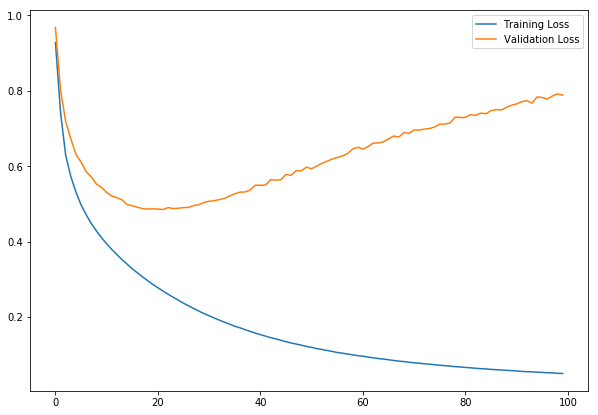

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
a, = plt.plot(history.history['loss'],label='Training Loss')
b, = plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(handles=[a,b])
plt.show()

# Creating inference models

In [26]:
encoder_model = Model(encoder_inputs,encoder_states)

In [27]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_input = [decoder_state_input_h,decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,initial_state=decoder_states_input)

decoder_states = [state_h,state_c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
                    [decoder_inputs]+decoder_states_input,
                    [decoder_outputs]+decoder_states)

In [28]:
# Define encoder model
encoder_model = Model(encoder_inputs, encoder_states)

In [29]:
# Define decoder model

# Inputs from the encoder
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

# Create a combined memory to input into the decoder
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Decoder
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

# Predict next char
decoder_outputs = decoder_dense(decoder_outputs)

# The model takes in the encoder memory plus it's own memory as an input and spits out 
# a prediction plus its own memory to be used for the next char
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [30]:
def decoder_sequence(input_seq):
    
    states_value = encoder_model.predict(input_seq)
    
    target_sequence = np.zeros([1,1,num_decoder_tokens])
    target_sequence[0,0,target_token_index["\t"]] = 1
    
    stop_condition = False
    
    decoded_sentence = ""
    
    while not stop_condition:
        output_tokens,h,c = decoder_model.predict([target_seq]+states_value)
        
        sampled_token_index = np.argmax(output_token[0,-1,:])
        
        sampled_char = reverse_target_char_index[sampled_token_index]
        

In [31]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = {i: char 
                            for char, i in input_token_index.items()}
reverse_target_char_index = {i: char 
                             for char, i in target_token_index.items()}

In [32]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    
    # Loop untill we recieve a stop sign
    while not stop_condition:
        # Get output and internal states of the decoder 
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Get the predicted token (the token with the highest score)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Get the character belonging to the token
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Append char to output
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

## Giving it a spin


In [33]:
my_text = 'Thank you'
placeholder = np.zeros((1,len(my_text)+10,num_encoder_tokens))

In [34]:
for i, char in enumerate(my_text):
    print(i,char, input_token_index[char])
    placeholder[0,i,input_token_index[char]] = 1

0 T 38
1 h 51
2 a 44
3 n 57
4 k 54
5   0
6 y 68
7 o 58
8 u 64


In [35]:
decode_sequence(placeholder)

'Merci !\n'